In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller #time series module
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import random

# 9.1 Forecasting with ARIMA

#### The name of the game is to predict the future, based on the past. As one can imagine, this is critically important in areas like finance, economics, healthcare, etc. In the advent where the predictor ($X$) is a function of the criterion ($Y$), i.e. $Y(X)$ is known, all of this is unecessary. Then you'd just predict by finding $Y(\hat{X})$

### 9.1.1 Stationarity
Before doing any time series analysis, we need to make the dataset "stationary" by ensuring that it have constant mean and variance and that the auto-covariance be fixed in time.

#### Apple data.

        date     open     high      low    close     volume  Name
0 2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416  AAPL
1 2013-02-11  68.0714  69.2771  67.6071  68.5614  129029425  AAPL
2 2013-02-12  68.5014  68.9114  66.8205  66.8428  151829363  AAPL
3 2013-02-13  66.7442  67.6628  66.1742  66.7156  118721995  AAPL
4 2013-02-14  66.3599  67.3771  66.2885  66.6556   88809154  AAPL


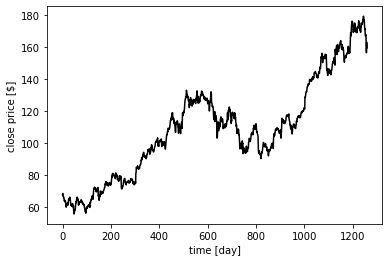

In [3]:
df = pd.read_csv('aapl_data.csv')
df['date'] = pd.to_datetime(df['date']) #pretty important: changing it to a datetime format
print(df.head())

fig, ax = plt.subplots()
ax.plot(df['close'], 'k-')
ax.set_ylabel('close price [$]')
ax.set_xlabel('time [day]');

#### Unit root test:
We need to test if the data is stationary. Spoiler alert: it's not. This can be found out by doing a test called the Augmented Dickey-Fuller test (ADF). If the data is the following $y_t = D_t + \zeta_t + \epsilon_t$, where $D_t$ i the deterministic portion, $\zeta_t$ is the stochastic component, and $\epsilon_t$ is the stationary error process.
The ADF test tries to see if the $\zeta_t$ term has a non-stationary (unit root) trend. 

In [4]:
def adf_test(data):
    result = adfuller(data, autolag='AIC')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])

adf_test(df['close'])

ADF Statistic: -0.6650906914089912
p-value: 0.8555858445838955
Critical Values: {'1%': -3.4355588184378574, '5%': -2.8638402312881497, '10%': -2.5679946684494275}


#### p-value is pretty high! >> .05, for instance. Null hypothesis ($H_0$) is that the data is non-stationary (while $H_1$ is that data is stationary). We cannot reject the null hypothesis. 

#### Differencing

        date     open     high      low    close     volume  Name   diff1
0 2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416  AAPL     NaN
1 2013-02-11  68.0714  69.2771  67.6071  68.5614  129029425  AAPL  0.7072
2 2013-02-12  68.5014  68.9114  66.8205  66.8428  151829363  AAPL -1.7186
3 2013-02-13  66.7442  67.6628  66.1742  66.7156  118721995  AAPL -0.1272
4 2013-02-14  66.3599  67.3771  66.2885  66.6556   88809154  AAPL -0.0600


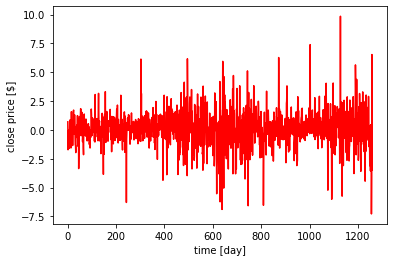

In [23]:
#### to achieve stationarity, let's do what is known as differencing. 
df['diff1'] = df['close'].diff()
print(df.head())

fig, ax = plt.subplots()
ax.plot(df['diff1'], 'r-')
ax.set_ylabel('close price [$]')
ax.set_xlabel('time [day]');

In [6]:
adf_test(df['diff1'][1:])

ADF Statistic: -34.820091250887394
p-value: 0.0
Critical Values: {'1%': -3.4355629707955395, '5%': -2.863842063387667, '10%': -2.567995644141416}


#### Woohoo! We can reject the null hypothesis and proceed. Stationarity has been achieved. But why does differencing work? 
Simply because a trend is a large scale feature. It spans the entire dataset, or a large portion of it. By subtracting the previous datapoint from the current, we are getting rid of that trend. Sometimes, the first difference is not good enough, and it requires several orders of differencing to achieve stationarity.

### 9.1.2 Getting model parameters (p,d,q)
- $p$ is the autoregressive order. It considers the relationship between current and past values. We can think of it as a memory. The higher $p$ is, the more the current value depends on the past. 
- $d$ is the differencing order. The number of times differencing was done to achieve stationarity. 
- $q$ is the window length of moving average

#### Optimizing for the hyperparameters is the next big step. Since differencing once was enough to achieve stationarity, we can fix $d = 1$. The other parameters would have to be optimized for

In [12]:
model = auto_arima(df['diff1'][1:], d=1, seasonal=False, stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5562.700, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5243.601, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5560.703, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5093.838, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4993.865, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4939.981, Time=0.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4913.348, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=4911.351, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=4937.984, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=1.21 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.79 s

#### Understanding the above. Akaike Information Criterion (AIC) is a metric that balances model fit and complexity. Honestly, it could be a bit of a crappy criterion to choose the best model but let's go forth and choose $p$=5, $q$=0, for now

In [16]:
ARIMA_model = ARIMA(df['diff1'][1:], order=(5, 1, 0))
model_fit = ARIMA_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  diff1   No. Observations:                 1258
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2449.676
Date:                Wed, 16 Aug 2023   AIC                           4911.351
Time:                        19:23:55   BIC                           4942.170
Sample:                             0   HQIC                          4922.934
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8192      0.023    -36.160      0.000      -0.864      -0.775
ar.L2         -0.6896      0.027    -25.646      0.000      -0.742      -0.637
ar.L3         -0.5280      0.031    -16.762      0.0

### 9.3.1 Forecasting, assessing accuracy of forecast

#### First, choose the number of steps in the future over which we want to forecast. Especially for non-seasonal data, ARIMA is just awful at predicting long-term behavior, and the number of steps would have to be a small number.

1259   -1.733219
1260   -1.743050
1261   -1.641930
1262   -0.936524
1263   -0.629135
Name: predicted_mean, dtype: float64
1259    157.806781
1260    156.063731
1261    154.421801
1262    153.485277
1263    152.856142
Name: predicted_mean, dtype: float64


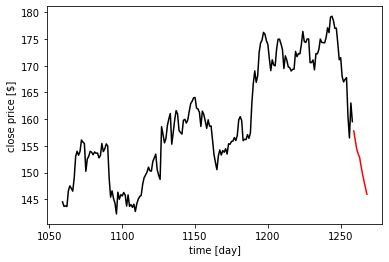

In [45]:
n=10 #number of future forecast steps
f = model_fit.forecast(steps=n) #forecast in differenced units
print(f.head())

#reverse differencing to go back to original scale
f_scaled = np.cumsum(f) + df['close'].iloc[-1]
print(f_scaled.head())

fig, ax = plt.subplots()
ax.plot(df['close'][-200:], 'k-')
ax.set_ylabel('close price [$]')
ax.set_xlabel('time [day]')
ax.plot(f_scaled, 'r-');

#### There you go! It's pretty shit. But that's the way to do it.

#### To assess the accuracy, split the original data into training and testing. Then do a forecast for the testing data, and compare with the actual data. Can compute an RMSE on that.

# 9.2 Granger Causality Test

### What came before: the chicken or the egg? Here's one way to find out.
Not but seriously, there are other not-so-dissimilar questions that pop up all the time. We might have a time series $S_1$ and another $S_2$ and we might want to see if they are linked by causation. In practice, one could be for instance the price of a soccer superstar and the other could be his goals/assist contributions. The price is driven by the latter (might not be directly so).

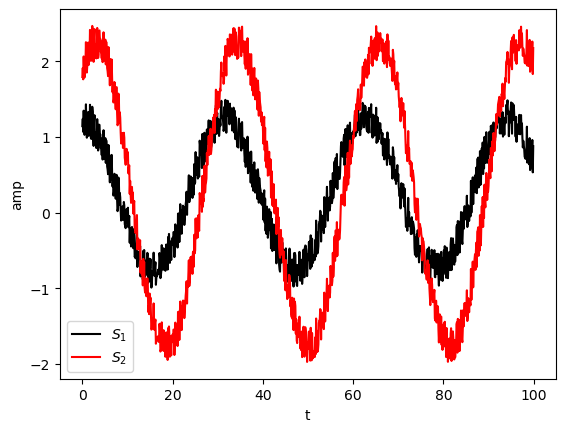

In [42]:
from statsmodels.tsa.stattools import grangercausalitytests #we'll import it, not going to code from scratch, although we will figure out what is going on.
t = np.arange(0, 100, .1)
eta = np.array([.5*random.random() for i in range(1000)])
s1 = np.cos(t/5) + eta
s2 = 2*np.cos((t-3)/5) + eta
fig, ax = plt.subplots()
ax.plot(t, s1, 'k-', label=r'$S_1$')
ax.plot(t, s2, 'r-', label=r'$S_2$')
ax.set_xlabel('t')
ax.set_ylabel('amp')
ax.legend();

#### For two datasets of this kind, we would expect the analysis to say that one causes the other, given that one function is just the other with a time delay
To quantify it, we use the F-statistic which computes the SSR (sum of residuals squared). The null hypothesis ($H_0$) is that one doesn't cause the other. The alternative hypothesis ($H_1$) is that one of the lagged series predicts the other. The F-statistic measures the reduction in SSR if we include the other lagged series. Higher F-score increases the probability of rejecting $H_0$. A p value can be computed as well. 

Let's test if $S_1$ predicts $S_2$ (which is a time-delayed version of $S_1$)

In [38]:
df = pd.DataFrame()
df['s1'] = s1
df['s2'] = s2
grangercausalitytests(df[['s2', 's1']], maxlag=[1]) #predictor is s1, response is s2. 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=83.2052 , p=0.0000  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=83.4558 , p=0.0000  , df=1
likelihood ratio test: chi2=80.1526 , p=0.0000  , df=1
parameter F test:         F=83.2052 , p=0.0000  , df_denom=996, df_num=1


{1: ({'ssr_ftest': (83.2051527597386, 3.9945692906997983e-19, 996.0, 1),
   'ssr_chi2test': (83.45577068973782, 6.515759202201489e-20, 1),
   'lrtest': (80.15258908622172, 3.46584228303594e-19, 1),
   'params_ftest': (83.20515275973865, 3.9945692906997983e-19, 996.0, 1.0)},
   array([[0., 1., 0.]])])}

#### As you can see, we have grounds to reject $H_0$ with that low of a p-value.
#### Let's try different (worse) functions to test against

In [35]:
s3 = 2*t + eta #just a straight line!
df['s3'] = s3
grangercausalitytests(df[['s1', 's3']], maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4729  , p=0.4918  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.4744  , p=0.4910  , df=1
likelihood ratio test: chi2=0.4743  , p=0.4910  , df=1
parameter F test:         F=0.4729  , p=0.4918  , df_denom=996, df_num=1


{1: ({'ssr_ftest': (0.4729409635570421, 0.4917974043535833, 996.0, 1),
   'ssr_chi2test': (0.4743654845316115, 0.4909856671544759, 1),
   'lrtest': (0.4742528962410688, 0.4910371162317395, 1),
   'params_ftest': (0.4729409635570019, 0.4917974043535833, 996.0, 1.0)},
   array([[0., 1., 0.]])])}

#### $H_0$ cannot be rejected, which is what we expected. Seems to be working! 
What about the reverse? If $S_1$ predicts $S_2$, could $S_2$ predict $S_1$?

In [44]:
grangercausalitytests(df[['s1', 's2']], maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.7664 , p=0.0000  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=21.8319 , p=0.0000  , df=1
likelihood ratio test: chi2=21.5968 , p=0.0000  , df=1
parameter F test:         F=21.7664 , p=0.0000  , df_denom=996, df_num=1


{1: ({'ssr_ftest': (21.76637914821393, 3.4994547324328417e-06, 996.0, 1),
   'ssr_chi2test': (21.831940531190476, 2.9760448152477834e-06, 1),
   'lrtest': (21.5968047346214, 3.3641181323883128e-06, 1),
   'params_ftest': (21.766379148213886, 3.4994547324328417e-06, 996.0, 1.0)},
   array([[0., 1., 0.]])])}

#### kind of, but not as well!